In [2]:

import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import numpy as np
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate

sys.path.insert(0, "/Users/mbornhol/git/neural-profiling")
from utils import eval

In [3]:
pre =  '/Users/mbornhol/git/neural-profiling/pre-trained/results/'
efficientnet_sphered = pd.read_csv(pre + 'res_enrichment_spherized.csv')

In [4]:
df = pd.read_csv('/Users/mbornhol/git/neural-profiling/training/runs/813/813_aggregated_median.csv', low_memory=False)

In [5]:
df_meta = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/data-prep/02_index_preperation/repurposing_info_external_moa_map_resolved.tsv', sep='\t')
df_meta = df_meta[['broad_sample', 'moa']]
df_meta.rename(columns = {'broad_sample' : 'Metadata_broad_sample', 'moa' : 'Metadata_moa'}, inplace=True)

In [6]:
# select subsections
index = pd.read_csv('/Users/mbornhol/git/neural-profiling/training/index/812_index.csv')

In [7]:
trained_class = index['Metadata_moa'].unique().tolist()
untrained_class = [c for c in df['Metadata_moa'].unique().tolist() if c not in trained_class]
untrained_class.append('unknown')

In [8]:
df_trained = df[df['Metadata_moa'].isin(trained_class)]
df_untrained = df[df['Metadata_moa'].isin(untrained_class)]
df_trained.to_csv('df_trained.csv', index=False)
df_untrained.to_csv('df_untrained.csv', index=False)

In [74]:
e = eval.evaluation(df_path= 'df_trained.csv')
con = e.norm_agg()
enr_trained = e.eval(con, operation = 'enrichment')
enr_trained

1280 features were identified


,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.407057,21.067404,0.0
1,0.990,0.322723,12.783311,0.0
2,0.985,0.269503,9.308899,0.0
3,0.980,0.232805,7.439977,0.0
4,0.975,0.204523,6.240412,0.0
5,0.970,0.182199,5.427167,0.0
6,0.965,0.164896,4.854823,0.0
7,0.960,0.150922,4.390670,0.0


In [75]:
e = eval.evaluation(df_path= 'df_untrained.csv')
con = e.norm_agg()
enr_untrained = e.eval(con, operation = 'enrichment')
enr_untrained

1280 features were identified


,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.423237,9.213805,5.490653e-38
1,0.990,0.328500,6.645564,2.001610e-42
2,0.985,0.274981,5.736911,2.072015e-47
3,0.980,0.238269,4.900795,3.890292e-46
4,0.975,0.211559,4.474299,3.094781e-47
5,0.970,0.189867,4.200022,7.529589e-49
6,0.965,0.172053,3.962331,1.394024e-49
7,0.960,0.156960,3.789199,1.301887e-50


In [86]:
e = eval.evaluation(df_path= '/Users/mbornhol/git/neural-profiling/training/runs/813/813_aggregated_median.csv')
con = e.norm_agg()
enr_all = e.eval(con, operation = 'enrichment')
prec_all = e.eval(con, operation = 'precision_recall')

1280 features were identified


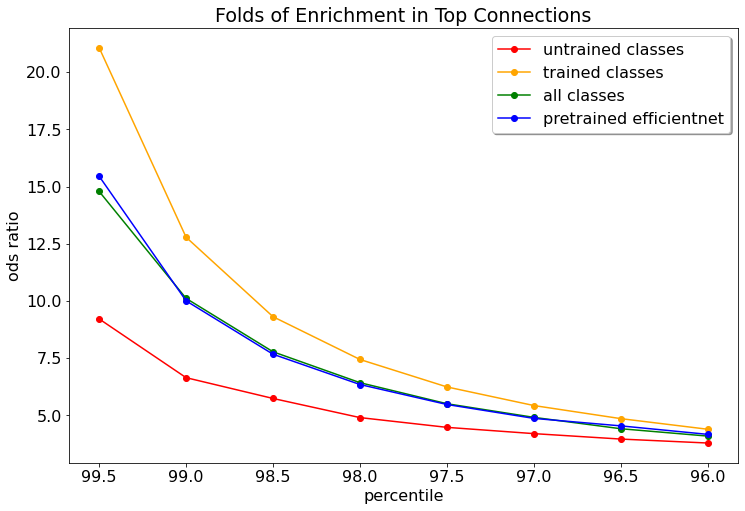

In [77]:

plt.style.use({'figure.facecolor':'white'})
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))
plt.title("Folds of Enrichment in Top Connections")
plt.plot(100*enr_untrained["enrichment_percentile"], enr_untrained["ods_ratio"], marker="o", color="red", label = 'untrained classes')
plt.plot(100*enr_trained["enrichment_percentile"], enr_trained["ods_ratio"], marker="o", color="orange", label = 'trained classes')
plt.plot(100*enr_all["enrichment_percentile"], enr_all["ods_ratio"], marker="o", color="green", label = 'all classes')
plt.plot(100*efficientnet_sphered["enrichment_percentile"], efficientnet_sphered["ods_ratio"], marker="o", color="blue", label = 'pretrained efficientnet')
plt.ylabel('ods ratio')
plt.xlabel('percentile')
ax.invert_xaxis()
plt.legend(loc = 'upper right', shadow=True)
plt.show()

In [13]:
features = [f for f in df.columns if f.startswith('eff')]
meta_features = [feat for feat in df.columns if feat not in features]

In [ ]:
sphere = normalize(
    profiles=df_trained,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = con[con["Metadata_broad_sample"] != 'DMSO']
k_range = [5, 10, 15, 20, 25, 30, 40, 50]
con = pd.merge(con, df_meta, how='left', on=['Metadata_broad_sample'])
prec_trained = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k=k_range,
    )

In [79]:
pr_av = []
for k in prec_trained.k.unique():
    pr_av.append(prec_trained.query("k==@k").mean().tolist())
prec_trained = pd.DataFrame(pr_av, columns=["k","precision","recall"])
prec_trained

,k,precision,recall
0,5.0,0.163265,0.010971
1,10.0,0.187755,0.023666
2,15.0,0.193197,0.036119
3,20.0,0.184694,0.048012
4,25.0,0.180408,0.058614
5,30.0,0.172109,0.066861
6,40.0,0.161735,0.081229
7,50.0,0.154286,0.095110


In [85]:
sphere = normalize(
    profiles=df_untrained,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, df_meta, how='left', on=['Metadata_broad_sample'])
con = con[con["Metadata_broad_sample"] != 'DMSO']
k_range = [5, 10, 15, 20, 25, 30, 40, 50]
prec_untrained = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k=k_range,
    )
pr_av = []
for k in prec_untrained.k.unique():
    pr_av.append(prec_untrained.query("k==@k").mean().tolist())
prec_untrained = pd.DataFrame(pr_av, columns=["k","precision","recall"])
prec_untrained

,k,precision,recall
0,5.0,0.032432,0.027838
1,10.0,0.028108,0.048018
2,15.0,0.022342,0.051712
3,20.0,0.019730,0.058739
4,25.0,0.019243,0.069009
5,30.0,0.018018,0.078018
6,40.0,0.015811,0.100180
7,50.0,0.014595,0.116577


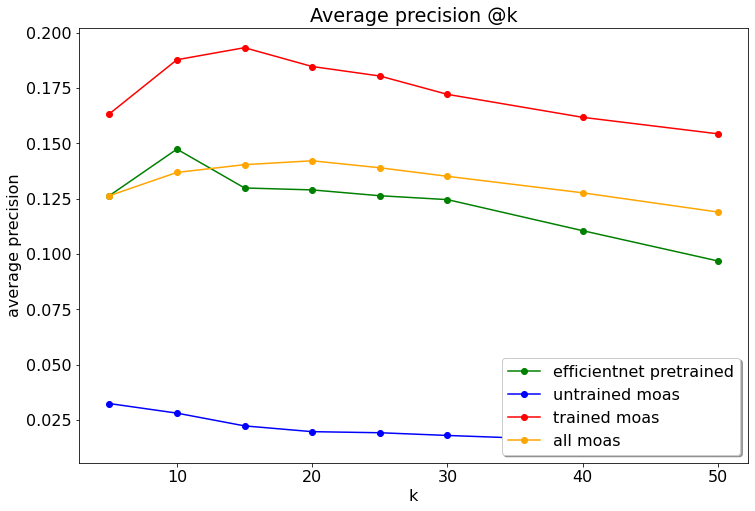

In [90]:
pre =  '/Users/mbornhol/git/neural-profiling/pre-trained/results/'
efficientnet = pd.read_csv(pre +'res_prec_spherized.csv')
plt.style.use({'figure.facecolor':'white'})
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))
plt.title("Average precision @k")
plt.plot(efficientnet["k"], efficientnet["precision"], marker="o", color="green", label = 'efficientnet pretrained')
plt.plot(prec_untrained["k"], prec_untrained["precision"], marker="o", color="blue", label = 'untrained moas')
plt.plot(prec_trained["k"], prec_trained["precision"], marker="o", color="red", label = 'trained moas')
plt.plot(prec_all["k"], prec_all["precision"], marker="o", color="orange", label = 'all moas')
plt.ylabel('average precision')
plt.xlabel('k')
plt.legend(loc = 'lower right', shadow=True)
plt.show()

In [ ]:
# DO SCATTER PLOT

In [1]:
sphere = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = con[con["Metadata_broad_sample"] != 'DMSO']
k_range = [100]
con = pd.merge(con, df_meta, how='left', on=['Metadata_broad_sample'])

NameError: name 'normalize' is not defined

In [ ]:
prec_all = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "Metadata_moa"],
        replicate_groups=["Metadata_moa"],
        operation="precision_recall",
        similarity_metric="pearson",
        precision_recall_k=k_range,
    )

In [2]:
class_nr = con['Metadata_moa'].value_counts()

NameError: name 'con' is not defined

In [3]:
prec_all['Nr_of_classes'] = class_nr[prec_all['Metadata_moa']].values

NameError: name 'class_nr' is not defined

In [28]:
prec_all['Training'] = ['trained' if c in trained_class else 'untrained' for c in prec_all['Metadata_moa']]
prec_all['color'] = [1 if c in trained_class else 0 for c in prec_all['Metadata_moa']]

In [23]:
# prec_all.sort_values(by=['precision'])

,Metadata_moa,k,precision,recall,Nr_of_classes,Training
0,11-beta hydroxysteroid dehydrogenase inhibitor...,10.0,0.0,0.000000,2,0
144,histamine receptor antagonist,10.0,0.0,0.000000,25,1
145,histamine receptor modulator,10.0,0.0,0.000000,2,0
146,hypoxia inducible factor inhibitor,10.0,0.0,0.000000,2,0
147,immunostimulant,10.0,0.0,0.000000,2,0
...,...,...,...,...,...,...
220,topoisomerase inhibitor,10.0,0.8,0.029412,17,1
190,proteasome inhibitor,10.0,0.9,0.450000,5,0
28,HDAC inhibitor,10.0,1.0,0.075758,12,1
38,MEK inhibitor,10.0,1.0,0.111111,10,1


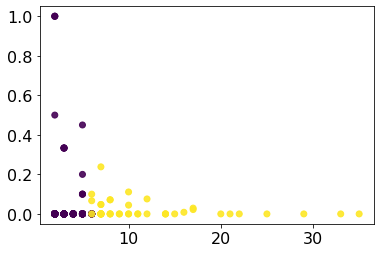

In [32]:
plt.style.use({'figure.facecolor':'white'})
plt.rcParams.update({'font.size': 16})
plt.scatter(prec_all['Nr_of_classes'], prec_all['recall'], c=prec_all['color'], marker='o', alpha=0.9)
plt.show()

# try other indexes
index 823

In [91]:
df = pd.read_csv('/Users/mbornhol/git/neural-profiling/training/runs/825/825_20_aggregated_median.csv', low_memory=False)

In [92]:
df_meta = pd.read_csv('/Users/mbornhol/git/neural-profiling/pre-trained/data-prep/02_index_preperation/repurposing_info_external_moa_map_resolved.tsv', sep='\t')
df_meta = df_meta[['broad_sample', 'moa']]
df_meta.rename(columns = {'broad_sample' : 'Metadata_broad_sample', 'moa' : 'Metadata_moa'}, inplace=True)

In [93]:
# select subsections
index = pd.read_csv('/Users/mbornhol/git/neural-profiling/training/index/823_index.csv')

In [94]:
trained_moa = index['Metadata_moa'].unique().tolist()
untrained_moa = [c for c in df['Metadata_moa'].unique().tolist() if c not in trained_moa]
untrained_moa.append('unknown')

In [95]:
df_trained = df[df['Metadata_moa'].isin(trained_moa)]
df_untrained = df[df['Metadata_moa'].isin(untrained_moa)]
df_trained.to_csv('df_trained.csv', index=False)
df_untrained.to_csv('df_untrained.csv', index=False)

In [96]:
e = eval.evaluation(df_path= 'df_trained.csv')
con = e.norm_agg()
enr_trained = e.eval(con, operation = 'enrichment')
enr_trained

1280 features were identified


,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.395093,11.141371,3.680728e-50
1,0.990,0.302922,8.105883,4.036641e-58
2,0.985,0.249160,6.291453,2.768669e-55
3,0.980,0.213907,5.237528,7.546235e-52
4,0.975,0.187067,4.886754,2.202374e-55
5,0.970,0.166475,4.435869,4.883756e-54
6,0.965,0.149930,4.319083,2.470852e-58
7,0.960,0.136387,4.017673,1.218124e-56


In [97]:
e = eval.evaluation(df_path= 'df_untrained.csv')
con = e.norm_agg()
enr_untrained = e.eval(con, operation = 'enrichment')
enr_untrained


1280 features were identified


,enrichment_percentile,threshold,ods_ratio,p-value
0,0.995,0.422338,8.849977,2.696197e-160
1,0.990,0.340210,6.612539,4.864340e-199
2,0.985,0.287050,5.284647,4.897093e-200
3,0.980,0.250955,4.847648,3.487577e-223
4,0.975,0.221965,4.471492,3.144034e-235
5,0.970,0.199516,4.212987,6.291181e-247
6,0.965,0.180759,3.949767,3.027774e-249
7,0.960,0.164599,3.716752,1.336416e-247


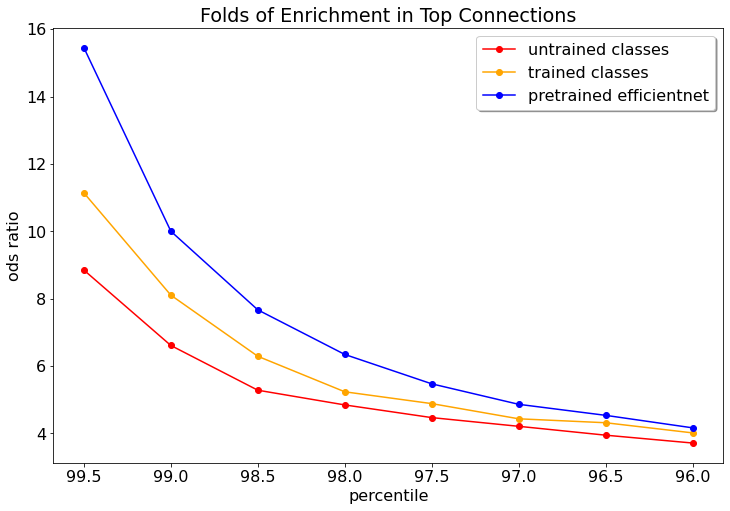

In [98]:
plt.style.use({'figure.facecolor':'white'})
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12,8))
plt.title("Folds of Enrichment in Top Connections")
plt.plot(100*enr_untrained["enrichment_percentile"], enr_untrained["ods_ratio"], marker="o", color="red", label = 'untrained classes')
plt.plot(100*enr_trained["enrichment_percentile"], enr_trained["ods_ratio"], marker="o", color="orange", label = 'trained classes')
plt.plot(100*efficientnet_sphered["enrichment_percentile"], efficientnet_sphered["ods_ratio"], marker="o", color="blue", label = 'pretrained efficientnet')
plt.ylabel('ods ratio')
plt.xlabel('percentile')
ax.invert_xaxis()
plt.legend(loc = 'upper right', shadow=True)
plt.show()

In [108]:
prec_untrained



,k,precision,recall
0,5.0,0.032432,0.027838
1,10.0,0.028108,0.048018
2,15.0,0.022342,0.051712
3,20.0,0.019730,0.058739
4,25.0,0.019243,0.069009
5,30.0,0.018018,0.078018
6,40.0,0.015811,0.100180
7,50.0,0.014595,0.116577
